# Market Basket Analysis

Market Basket Analysis (MBA) is a data mining analytics technique to uncover associations between products or product grouping. By exploring interesting patterns from an extensive collection of data, MBA aims to understand/reveal customer purchase behaviors based upon the theory that if you purchased a certain set of products, then you are more (or less) likely to buy another group of products. In other words, MBA allows retailers to identify the relationship between the items that customers buy, revealing patterns of items often purchased together.

A widely used approach to explore these patterns is by constructing ***association rules*** such as
- **if** bought *ITEM_1* **then** will buy *ITEM_2* with **confidence** *X*.

These associations do not have to be 1-to-1 rules. They can involve many items. For example, a person in a supermarket may add eggs to his/her cart, then an MBA application may suggest that the person will also buy some bread and/or flour:

+ **if** bought *EGGS* **then** will buy [*BREAD* with confidence *0.2*; *FLOUR* with confidence 0.05].

However, if the person now decides to add flour to his/her cart, the new association rule could be as showing below, suggesting ingredients to make a cake.

+ **if** bought [*EGGS, FLOUR*] **then** will buy [*SUGGAR* with confidence 0.45; BAKING POWDER with confidence 0.12; *BREAD* with confidence *0.03*].

There are many real scenarios where MBA plays a central role in data analysis, such as supermarket transactions, online orders or credit card history. Marketers may use these association rules to arrange correlated products closer to each other on store shelves or make online suggestions so that customers buy more items. Some questions that an MBA can usually help retailers to answer are:

- What items are often purchased together?
- Given a basket, what items should be suggested?
- How should items be placed together on the shelves?

### Objective

The goal is to develop an MBA algorithm for revealing patterns by creating association rules in a big dataset with more than three million supermarket transactions. However, mining association rules for large datasets is a very computationally intensive problem, which makes it almost impractical to perform it without a distributed system. Hence, to run the algorithm, we need access to a distributed cloud computing cluster with hundreds of cores.

To this end, a **MapReduce** algorithm will be implemented upon the [Apache Spark](http://spark.apache.org) framework, a fast cluster computing system. In a nutshell, Spark is an open source framework designed with a *scale-out* methodology which makes it a very powerful tool for programmers or application developers to perform a massive volume of computations and data processing in distributed environments. Spark provides high-level APIs that make it easy to build parallel apps without needing to worry about how your code and data are parallelized/distributed thought the computing cluster.

The implementation will follow the Market Basket Analysis algorithm presented by Jongwook Woo and Yuhang Xu (2012).

## 1. Setting up Spark

Spark runs on both Windows and UNIX-like systems (e.g., Linux, Mac OS). It's easy to run locally on one machine — all we need is to have Java installed on system PATH, or the JAVA_HOME environment variable pointing to a Java installation.

It is mandatory to have the **JDK v8/11** installed, as Spark currently only support this version.
go to [Java's web page](https://www.oracle.com/java/technologies/javase-downloads.html) to download and install a Java Virtual Machine.
Set the environment variable JAVA_HOME to use JDK v8/11.


#### Test Spark
Using the following code to if the Spark is installed correctly.

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 1.1 Products Counting Example

The example counts how many times the products are purchased using a toy dataset.

The main entry point to start programming with Spark is the [RDD API](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.html#rdd-apis), an excellent Spark abstraction to work with the MapReduce framework. Some useful functions that the RDD API offers are:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [ ]:
from pyspark.sql import SparkSession
def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()

# Read a toy dataset
toy = spark.read.csv('s3://projectnz/toy.csv', header=True)
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product, preservesPartitioning=False)
print("\nMapped products:\n\t", toy_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

#print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|    a;b;c;f|
|       2|    d;b;a;e|
|       3|        c;b|
|       4|        b;c|
+--------+-----------+

Toy dataframe as a RDD object (list of Row objects):
	 [Row(order_id='1', transaction='a;b;c;f'), Row(order_id='2', transaction='d;b;a;e'), Row(order_id='3', transaction='c;b'), Row(order_id='4', transaction='b;c')]

Mapped products:
	 [('a', 1), ('b', 1), ('c', 1), ('f', 1), ('d', 1), ('b', 1), ('a', 1), ('e', 1), ('c', 1), ('b', 1), ('b', 1), ('c', 1)]

Reduced (merged) products:
	 [('a', 2), ('b', 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      b|            4|
|      c|            3|
|      f|            1|
|      d|            1|
|      e|            1|
+-------+-------------+

### 1.2 Working with Spark's Dataframe

In the example above, we briefly used a Spark's Dataframe class, but only to obtain an RDD object with ```toy.rdd``` and to print the data as a structured table with the ```show()``` function. However, [Dataframe](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#) is a crucial part of the current Spark release and is built upon the RDD API. It is a distributed collection of rows under named columns, the same as a table in a relational database. Spark's Dataframe works similarly as [Pandas'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). In fact, we can export (obtain) a Spark's dataframe to (from) a pandas' data frame with the function ```toPandas()``` (```spark.createDataFrame```).

A central functionality of the data frame is to profit from the [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), a module that allows SQL queries over structured data. For example, the same 'product counting example' could have been implemented as a sequence of SQL operations over the data:  

In [ ]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_toy.select(df_toy.products)\
    .groupBy(df_toy.products)\
    .agg(f.count('products').alias('count_product'))\
    .sort('count_product', ascending=False)\
    .show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|    a;b;c;f|       a|
|       1|    a;b;c;f|       b|
|       1|    a;b;c;f|       c|
|       1|    a;b;c;f|       f|
|       2|    d;b;a;e|       d|
|       2|    d;b;a;e|       b|
|       2|    d;b;a;e|       a|
|       2|    d;b;a;e|       e|
|       3|        c;b|       c|
|       3|        c;b|       b|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Couting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       e|            1|
|       f|            1|
|       d|            1|
+--------+-------------+

Also, the same SQL operations performed above could have been done with a traditional SQL language query as showing below:

In [ ]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
|       e|            1|
|       f|            1|
+--------+-------------+

## 2. MBA Algorithm
The following sections explain how you should develop each step of the MapReduce algorithm for our supermarket application. Figure workflow.pdf illustrates each step of the algorithm.

### 2.1 Map to Patterns
For a given set of transactions (i.e., the rows of our toy dataset), each transaction must be **mapped** into a set of *purchase patterns* found within the transaction. Formally, these patterns are subsets of products that represent a group of items bought together.


In [ ]:
import itertools

def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    """
    receives a transaction and returns the patterns found in it.
    Mapped elements are a tuple (KEY, VALUE), where the KEY is a tuple of product names; the VALUE is its number of apparitions.
    """
    # row is Row object (https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Row.html)

    products = row.transaction.split(';') # split products from the column transaction
    combinations = []
    for r in range(1, 4):
        if r <= len(products):
            combinations_object = itertools.combinations(products, r)
            combinations += list(combinations_object)
    for p in combinations:
        yield (p, 1)


toy_rdd = toy.rdd
"""
Since each entry (transaction) of the map function will yield more than one KEY-VALUE element,  a *flatMap* must be invoked for this step.
"""
patterns_rdd = toy_rdd.flatMap(map_to_patterns)

# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|         ('b',)|          1|
|         ('c',)|          1|
|         ('f',)|          1|
|     ('a', 'b')|          1|
|     ('a', 'c')|          1|
|     ('a', 'f')|          1|
|     ('b', 'c')|          1|
|     ('b', 'f')|          1|
|     ('c', 'f')|          1|
|('a', 'b', 'c')|          1|
|('a', 'b', 'f')|          1|
|('a', 'c', 'f')|          1|
|('b', 'c', 'f')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|         ('a',)|          1|
|         ('e',)|          1|
|     ('d', 'b')|          1|
|     ('d', 'a')|          1|
|     ('d', 'e')|          1|
|     ('b', 'a')|          1|
|     ('b', 'e')|          1|
|     ('a', 'e')|          1|
|('d', 'b', 'a')|          1|
|('d', 'b', 'e')|          1|
|('d', 'a', 'e')|          1|
|('b', 'a', 'e')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('c'

### 2.2 Reduce patterns
Once different CPUs processed the transactions, a **reduce** function must take place to combine identical KEYS (the subset of products) and compute the total number of its occurrences in the entire dataset. In other words, this reduce procedure must sum the *VALUE* of each identical KEY.

In [ ]:

def reduce_patterns(value1, value2):
    """
    combine identical KEYS (the subset of products) and compute the total number of its occurrences
    """
    return value1 + value2


combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns) #TODO

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|         ('b',)|                   4|
|         ('c',)|                   3|
|         ('f',)|                   1|
|     ('a', 'b')|                   1|
|     ('a', 'c')|                   1|
|     ('a', 'f')|                   1|
|     ('b', 'c')|                   2|
|     ('b', 'f')|                   1|
|     ('c', 'f')|                   1|
|('a', 'b', 'c')|                   1|
|('a', 'b', 'f')|                   1|
|('a', 'c', 'f')|                   1|
|('b', 'c', 'f')|                   1|
|         ('d',)|                   1|
|         ('e',)|                   1|
|     ('d', 'b')|                   1|
|     ('d', 'a')|                   1|
|     ('d', 'e')|                   1|
|     ('b', 'a')|                   1|
|     ('b', 'e')|                   1|
|     ('a', 'e')|                   1|
|('d', 'b', 'a')|        

### 2.3 Map to subpatterns
Next, another **map** function should be applied to generate subpatterns. Once again, the subpatterns are KEY-VALUE elements, where the KEY is a subset of products as well. However, creating the subpattern's KEY is a different procedure. This time, the idea is to break down the list of products of each pattern (pattern KEY), remove one product at a time, and yield the resulting list as the new subpattern KEY.

For example, for a given pattern $P$ with three products, $p_1, p_2 $ and $p_3$, three new subpatterns KEYs are going to be created: (i) remove $p_1$ and yield ($p_2, p_3$); (ii) remove $p_2$ and yield ($p_1,p_3$); and (iii) remove $p_3$ and yield ($p_1,p_2$).

Additionally, the subpattern's VALUE structure will also be different. Instead of just single integer value as we had in the patterns, this time a *tuple* should be created for the subpattern VALUE. This tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared. For example above, the values should be ($p_1,v$), ($p_2,v$) and ($p_3,v$), respectively, where $v$ is the VALUE of the pattern.

The idea behind subpatterns is to create **rules** such as: when the products of KEY were bought, the item present in the VALUE was also bought *v* times. Furthermore, each pattern should also yield a subpattern where the KEY is the same list of products of the pattern, but the VALUE is a tuple with a null product (None) and the number of times the pattern appeared. This element will be useful to keep track of how many times such a pattern was found and later will be used to compute the confidence value when generating the association rules.

In [ ]:
#from copy import deepcopy

def map_to_subpatterns(pattern):
    """
    KEY: a subset of products; break down the list of products of each pattern (pattern KEY), remove one product at a time.
    VALUE: tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared.
    """
    result = []

    result.append((pattern[0], (None, pattern[1])))
    if len(pattern[0]) > 1:
        for i in range(len(pattern[0])):
            result.append((pattern[0][:i] + pattern[0][(i + 1):], (pattern[0][i], pattern[1])))

    for sublist in result:
        yield sublist


subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)   #TODO

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|         ('b',)|(None, 4)|
|         ('c',)|(None, 3)|
|         ('f',)|(None, 1)|
|     ('a', 'b')|(None, 1)|
|         ('b',)| ('a', 1)|
|         ('a',)| ('b', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|     ('a', 'f')|(None, 1)|
|         ('f',)| ('a', 1)|
|         ('a',)| ('f', 1)|
|     ('b', 'c')|(None, 2)|
|         ('c',)| ('b', 2)|
|         ('b',)| ('c', 2)|
|     ('b', 'f')|(None, 1)|
|         ('f',)| ('b', 1)|
|         ('b',)| ('f', 1)|
|     ('c', 'f')|(None, 1)|
|         ('f',)| ('c', 1)|
|         ('c',)| ('f', 1)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|('a', 'b', 'f')|(None, 1)|
|     ('b', 'f')| ('a', 1)|
|     ('a', 'f')| ('b', 1)|
|     ('a', 'b')| ('f', 1)|
|('a', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('a', 1)|
|     ('a', 'f')| ('

### 2.4 Reduce Subpatterns
Once again, a **reduce** function will be required to group all the subpatterns by their KEY. The objective of this reducing procedure is to create a list of all **rules** that appeared in KEY. Hence, the expected output resulting from this reduce function is also a KEY-VALUE element, where the KEY is the subpattern's KEY, and the VALUE is a group containing all the VALUEs of the subpatterns that share the same KEY.

In [ ]:
combined_rules = subpatterns_rdd.groupByKey().mapValues(list)

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------------------------------------------------------------------------------+
|subpatterns    |combined_rules                                                                   |
+---------------+---------------------------------------------------------------------------------+
|('a',)         |[(None, 2), ('b', 1), ('c', 1), ('f', 1), ('d', 1), ('b', 1), ('e', 1)]          |
|('b',)         |[(None, 4), ('a', 1), ('c', 2), ('f', 1), ('d', 1), ('a', 1), ('e', 1), ('c', 1)]|
|('c',)         |[(None, 3), ('a', 1), ('b', 2), ('f', 1), ('b', 1)]                              |
|('f',)         |[(None, 1), ('a', 1), ('b', 1), ('c', 1)]                                        |
|('a', 'b')     |[(None, 1), ('c', 1), ('f', 1)]                                                  |
|('a', 'c')     |[(None, 1), ('b', 1), ('f', 1)]                                                  |
|('a', 'f')     |[(None, 1), ('b', 1), ('c', 1)]                                                  |


## 2.5. Map to Association Rules
Finally, the last step of the algorithm is to create the association rules to perform the market basket analysis. The goal of this map function is to calculate the **confidence** level of buying a product, knowing that there is already a set of products in the basket. Thus, the KEY of the subpattern is the set of products placed in the basket and, for each product present in the list of rules, i.e., in the VALUE, the confidence can be calculated as:

\begin{align*}
\frac{\text{number of times the product was bought together with KEY }}{\text{number of times the KEY appeared}}
\end{align*}

For the example given in the Figure workflow, *coffee* was bought 20 times and, in 17 of them, *milk* was bought together. Then, the confidence level of buying *milk* knowing that *coffee* is in the basket is $\frac{17}{20} = 0.85$, which means that in 85% of the times the coffee was bought, milk was purchased as well.

In [ ]:
# The (None, num) should always be the first element. If yes, use the 2nd, otherwise, use the 1st.

def map_to_assoc_rules(rule):
    for i in rule:
        if i[0] == None:
            appearance = i[1]
    for i in rule:
        if i[0] != None:
            confidence = float(i[1])/ appearance
            yield (i[0], confidence)

# def map_to_assoc_rules(rule):
#     """
#     KEY:  KEY of the subpatterns
#     VALUE: the confidence level of each product in the list of rules
#     return: key, [(product, confidence_level)...]
#     """
#    # print(rule)
#     for i in rule[1:]:
#         confidence = float(i[1])/ rule[0][1]
#         yield (i[0], confidence)


assoc_rules = combined_rules.mapValues(map_to_assoc_rules).mapValues(list) #TODO

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------------------------------------------------------------------------------------------------+
|patterns       |association_rules                                                                                           |
+---------------+------------------------------------------------------------------------------------------------------------+
|('a',)         |[('b', 0.5), ('c', 0.5), ('f', 0.5), ('d', 0.5), ('b', 0.5), ('e', 0.5)]                                    |
|('b',)         |[('a', 0.25), ('c', 0.5), ('f', 0.25), ('d', 0.25), ('a', 0.25), ('e', 0.25), ('c', 0.25)]                  |
|('c',)         |[('a', 0.3333333333333333), ('b', 0.6666666666666666), ('f', 0.3333333333333333), ('b', 0.3333333333333333)]|
|('f',)         |[('a', 1.0), ('b', 1.0), ('c', 1.0)]                                                                        |
|('a', 'b')     |[('c', 1.0), ('f', 1.0)]                                                                      

## 3. Instacart dataset

Now that the MBA algorithm ready to be used, it is time to work on the real dataset. We download the [instacart](https://www.dropbox.com/s/qa7nsw2at3hsbmp/instacart.zip?dl=0) dataset and read its [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) to understand how the dataset is structured.

Before applying the developed algorithm on the instacart dataset, we first filter the transactions to be in the same format defined by the algorithm (one transaction per row). To manipulate the data, we use Spark's data frame and the SQL module.

The following code cell uses the Spark SQL module to read the orders from the ``order_products__train.csv`` and the detailed information from ``orders.csv`` and ``products.csv`` to construct a data frame that contains a list of all products ever purchased by each user.

In [ ]:
#

df_order_prod = spark.read.csv('instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv('instacart/orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv('instacart/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)


"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products'
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=80)


# USING DATAFRAME OPERATIONS
# df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

### 3.1 Business Insights

Considering only the orders of ``order_products__train.csv``, we will answer the following questions using Spark SQL module with SQL or data frame.

1. What are the top 10 products which have the highest probability of being reordered? Consider only products purchased at least 40 times for this task.
2. What are the top 3 most purchased products of each department?
4. What is the average basket size for each day of the week?


### 1) top 10 products reordered

In [ ]:
# 3.1 step 1
df_op_p = spark.sql('SELECT op.order_id, op.reordered, p.product_id, p.product_name, p.department_id'
               ' FROM order_prod op'
               ' INNER JOIN products p ON op.product_id = p.product_id') #.show(10, truncate=200)
df_op_p.createOrReplaceTempView("op_p")

# 3.1 products purchased >= 40 times.
df_p_purchased = spark.sql(' select * from'
          ' (select distinct product_name, product_id,'
          ' count(*) over(partition by product_id) as num_purchased'
          ' from op_p) a'
          ' where a.num_purchased >= 40')
df_p_purchased.createOrReplaceTempView("p_purchased")

# 3.1 top 10 reordered products, considering product purchased at least 40 times.
spark.sql('select distinct p_purchased.product_name, a.num_reordered from '
          '(select product_id, SUM(reordered) AS num_reordered '
          ' from op_p'
          ' group by product_id) a, p_purchased'
          ' where a.product_id = p_purchased.product_id order by 2 desc limit 10').show(truncate=False)

+----------------------+-------------+
|product_name          |num_reordered|
+----------------------+-------------+
|Banana                |16557        |
|Bag of Organic Bananas|13362        |
|Organic Strawberries  |8603         |
|Organic Baby Spinach  |8055         |
|Organic Avocado       |6226         |
|Organic Hass Avocado  |6042         |
|Large Lemon           |5923         |
|Strawberries          |4786         |
|Organic Raspberries   |4279         |
|Limes                 |4234         |
+----------------------+-------------+



### 2)  top 3 most purchased products of each department

In [ ]:

df_sorted_prod = spark.sql('select product_name, department_id, cnt_prod,'
                           ' row_number() over (partition by department_id order by cnt_prod desc) as prod_rank from '
                           ' (select distinct department_id, product_name,'
                           ' count(product_id) over(partition by department_id, product_id) as cnt_prod'
                           ' from op_p) a')
df_sorted_prod.createOrReplaceTempView("sorted_prod")
spark.sql('select prod_rank, product_name, department_id, cnt_prod from sorted_prod where prod_rank < 4').show(70, truncate=False)

+---------+-----------------------------------------------------+-------------+--------+
|prod_rank|product_name                                         |department_id|cnt_prod|
+---------+-----------------------------------------------------+-------------+--------+
|1        |Sparkling Water Grapefruit                           |7            |3359    |
|2        |Spring Water                                         |7            |2225    |
|3        |Lime Sparkling Water                                 |7            |1966    |
|1        |Organic Black Beans                                  |15           |1576    |
|2        |No Salt Added Black Beans                            |15           |1250    |
|3        |Organic Garbanzo Beans                               |15           |1141    |
|1        |Cotton Swabs                                         |11           |258     |
|2        |Lavender Hand Soap                                   |11           |258     |
|3        |Lemon Verb

### 3) What is the average basket size for each day of the week?

In [ ]:
# dataframe order_prod + orders
df_op_o = spark.sql('SELECT op.order_id, op.add_to_cart_order, o.order_dow'
               ' FROM order_prod op'
               ' INNER JOIN orders o ON op.order_id = o.order_id')
df_op_o.createOrReplaceTempView("op_o")


# number of orders each day of the week
num_orders = spark.sql('select count(*) as num_orders, order_dow from'
          ' (select distinct order_id, order_dow from op_o) group by order_dow')
#num_orders.show()

# basket_size each day
basket_sz = spark.sql('select order_dow, count(add_to_cart_order) as basket_size from op_o'
          ' group by order_dow')
#basket_sz.show()

# average bac=sket size, each day of the week
result = basket_sz.join(num_orders, basket_sz.order_dow == num_orders.order_dow, 'inner')\
.select(basket_sz.order_dow, f.round(basket_sz.basket_size/num_orders.num_orders, 2).alias('avg_size'))\
.orderBy('avg_size', ascending=False)
result.show()

+---------+--------+
|order_dow|avg_size|
+---------+--------+
|        0|    11.8|
|        6|   10.97|
|        1|   10.47|
|        5|   10.16|
|        2|    9.96|
|        3|    9.84|
|        4|    9.74|
+---------+--------+



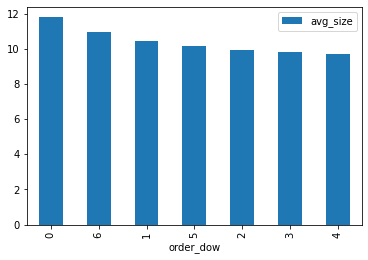

In [ ]:
import pandas as pd

df = result.toPandas()
_ = df.plot.bar(x='order_dow', y='avg_size')

### 3.2 Run MBA for the training set

Using the orders from the ``order_products__train.csv``, we create a data frame where each row contains the column “transaction” with the list of purchased products. In sequence, run the MBA algorithm for this set of transactions.

- We will report the time spent to perform this task.

In [ ]:
%%time
"""
TODO: create a query to create and sctruct the transactions
"""

df32 = spark.sql('SELECT op.order_id, COLLECT_LIST(p.product_name) AS products'
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY op.order_id ORDER BY op.order_id')

df32_trans = df32.select(df32.order_id, f.array_join(df32.products, ';').alias("transaction"))


Wall time: 17.9 ms


In [ ]:
df32_trans.show(2, truncate=100)

+--------+----------------------------------------------------------------------------------------------------+
|order_id|                                                                                         transaction|
+--------+----------------------------------------------------------------------------------------------------+
|       1|Bulgarian Yogurt;Organic 4% Milk Fat Whole Milk Cottage Cheese;Organic Celery Hearts;Cucumber Kir...|
|      36|Grated Pecorino Romano Cheese;Spring Water;Organic Half & Half;Super Greens Salad;Cage Free Extra...|
+--------+----------------------------------------------------------------------------------------------------+
only showing top 2 rows



### map to pattern 2.1

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""

df32_trans_rdd = df32_trans.rdd
patterns_rdd = df32_trans_rdd.flatMap(map_to_patterns)

# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(5, truncate=100)

+--------------------------------------------------+-----------+
|                                          patterns|occurrences|
+--------------------------------------------------+-----------+
|                             ('Bulgarian Yogurt',)|          1|
|('Organic 4% Milk Fat Whole Milk Cottage Cheese',)|          1|
|                        ('Organic Celery Hearts',)|          1|
|                               ('Cucumber Kirby',)|          1|
|         ('Lightly Smoked Sardines in Olive Oil',)|          1|
+--------------------------------------------------+-----------+
only showing top 5 rows

Wall time: 1.22 s


### reduce to pattern 2.2

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(5, truncate=100)

+--------------------------------------------------------------------------+--------------------+
|                                                                  patterns|combined_occurrences|
+--------------------------------------------------------------------------+--------------------+
|           ('Spring Water', 'Super Greens Salad', 'Prosciutto, Americano')|                   1|
|              ('Organic Raw Unfiltered Apple Cider Vinegar', 'Fresh Dill')|                   1|
|                     ('Organic Raspberries', 'Organic Whole Strawberries')|                 123|
|('Organic Chocolate Almondmilk Pudding', 'Organic Extra Virgin Oil Olive')|                   1|
|                          ('Tomatoes, Crushed, Organic', 'Organic Garlic')|                   2|
+--------------------------------------------------------------------------+--------------------+
only showing top 5 rows

Wall time: 4min 2s


### map to subpatterns 2.3

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(5, truncate=False)

+---------------------------------------------------------------+----------------------------+
|subpatterns                                                    |rules                       |
+---------------------------------------------------------------+----------------------------+
|('Spring Water', 'Super Greens Salad', 'Prosciutto, Americano')|(None, 1)                   |
|('Super Greens Salad', 'Prosciutto, Americano')                |('Spring Water', 1)         |
|('Spring Water', 'Prosciutto, Americano')                      |('Super Greens Salad', 1)   |
|('Spring Water', 'Super Greens Salad')                         |('Prosciutto, Americano', 1)|
|('Organic Raw Unfiltered Apple Cider Vinegar', 'Fresh Dill')   |(None, 1)                   |
+---------------------------------------------------------------+----------------------------+
only showing top 5 rows

Wall time: 1.82 s


### reduce to subpatterns 2.4

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
combined_rules = subpatterns_rdd.groupByKey().mapValues(list)  #TODO

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(2, truncate=120)

+---------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|                                                    subpatterns|                                                                                                          combined_rules|
+---------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|('Spring Water', 'Super Greens Salad', 'Prosciutto, Americano')|                                                                                                             [(None, 1)]|
|   ('Organic Raw Unfiltered Apple Cider Vinegar', 'Fresh Dill')|[(None, 1), ('Organic Baby Arugula', 1), ('Flat Parsley, Bunch', 1), ('Organic Biologique Limes', 1), ('Bunched Cilan...|
+---------------------------------------------------------------+

### map to association rule 2.5

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
assoc_rules = combined_rules.mapValues(map_to_assoc_rules).mapValues(list) #TODO

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(5, truncate=100)

+--------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                  patterns|                                                                                   association_rules|
+--------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|           ('Spring Water', 'Super Greens Salad', 'Prosciutto, Americano')|                                                                                                  []|
|              ('Organic Raw Unfiltered Apple Cider Vinegar', 'Fresh Dill')|[('Organic Baby Arugula', 1.0), ('Flat Parsley, Bunch', 1.0), ('Organic Biologique Limes', 1.0), ...|
|                     ('Organic Raspberries', 'Organic Whole Strawberries')|[('Organic Whole Milk', 0.02439024

#### Total time: 1.22s + 4 min 2s + 1.82s + 14min 43s + 7.75s ~= 19 min


### 3.3 Run MBA for the whole dataset

As we have noticed, even for a not so large data set (the training file has only 131K orders), the MBA algorithm is computationally expensive. Now, we will repeat the process, but using the Amazon Web Services (AWS) to create a large computer cluster.

This time, we will work with the ``order_products__test.csv`` file, which contains more than 3M orders.

**EXPECTED OUTPUT**

After running the MBA for the larger collection of orders, randomly select ONE product purchased in ``order_products__test`` and print the association rules (product name and association value) of this product, i.e., when the product is alone in the basket. The output should be formatted in a table, where each row containing the information of one associated product.
We will:
- Print both ID and Name of the random selected product.
- Report the execution time.

In [ ]:
# load order_products__test.csv from s3. It was implemented for prior. did not change the variable name for test.csv.

df_order_prod_prior = spark.read.csv('s3://projectnznz/order_products__test.csv', header=True, sep=',', inferSchema=True)
print('order_products__test.csv')
df_order_prod_prior.show(5)
df_order_prod_prior.createOrReplaceTempView("order_prod_prior") # creates table 'order_prod'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

order_products__test.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       4|     46842|                1|        0|
|       4|     26434|                2|        1|
|       4|     39758|                3|        1|
|       4|     27761|                4|        1|
|       4|     10054|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

In [ ]:
# load order, product from s3

df_orders = spark.read.csv('s3://projectnznz/orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv('s3://projectnznz/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)

df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows

products.csv
+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+--------

In [ ]:
#%%time
"""
TODO: create a query to create and sctruct the transactions from the order_products__test.csv file
"""
from time import time
start = time()

df33 = spark.sql('SELECT op.order_id, COLLECT_LIST(p.product_name) AS products'
               ' FROM orders o '
               ' INNER JOIN order_prod_prior op ON op.order_id = o.order_id'
               ' INNER JOIN products p ON op.product_id = p.product_id'
               ' GROUP BY op.order_id ORDER BY op.order_id')

df33_trans = df33.select(df33.order_id, f.array_join(df33.products, ';').alias("transaction"))

df33_trans_rdd = df33_trans.rdd
df33_trans_rdd.take(2)

print(f"Total time: {time() - start} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total time: 8.446747779846191 seconds

In [ ]:
df33_trans_rdd.take(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(order_id=4, transaction="Plain Pre-Sliced Bagels;Honey/Lemon Cough Drops;Chewy 25% Low Sugar Chocolate Chip Granola;Oats & Chocolate Chewy Bars;Kellogg's Nutri-Grain Apple Cinnamon Cereal;Nutri-Grain Soft Baked Strawberry Cereal Breakfast Bars;Kellogg's Nutri-Grain Blueberry Cereal;Tiny Twists Pretzels;Traditional Snack Mix;Goldfish Cheddar Baked Snack Crackers;Original Orange Juice;Sugarfree Energy Drink;Energy Drink"), Row(order_id=5, transaction="Bag of Organic Bananas;Just Crisp, Parmesan;Fresh Fruit Salad;Organic Raspberries;2% Reduced Fat Milk;Sensitive Toilet Paper;Natural Artesian Water, Mini & Mobile;Matzos, Thin, Tea;Boneless Skinless Chicken Breast Fillets;Mini Original Babybel Cheese;Macaroni And Cheese;Clementines;Biscuits Orange Pim's;Dairy Milk Fruit & Nut Chocolate Bar;Artichokes;Apricot Preserves;One Ply Choose A Size Big Roll Paper Towel Rolls;Wafer, Chocolate;French Lavender Hand Wash;American Slices Cheese;Everyday  Facial Tissues;Organic Hass Avocado;Spaghetti

In [ ]:
#%%time
"""
TODO: run the MBA algorithm and print the requested output
"""
from time import time
start = time()

# map to pattern 2.1
patterns_rdd = df33_trans_rdd.flatMap(map_to_patterns)
# Output as dataframe
#patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(5, truncate=False)

# reduce to pattern 2.2
combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)
# Output as dataframe
#combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(5, truncate=False)

#map to subpatterns 2.3
subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)
# Output as dataframe
#subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(2, truncate=False)

# reduce to subpatterns 2.4
combined_rules = subpatterns_rdd.groupByKey().mapValues(list)
# Output as dataframe
#combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(2, truncate=100)

#map to association rule 2.5
assoc_rules = combined_rules.mapValues(map_to_assoc_rules).mapValues(list)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(5, truncate=100)

print(f"Total time: {time() - start} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                   patterns|                                                                                   association_rules|
+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|('Organic Whole String Cheese', 'Parmesan Shredded Cheese')|[('Organic Medium Chili', 0.07692307692307693), ('Yummy Bears Organics Multi Vitamin', 0.07692307...|
|                         ('Ground Black Silk Dark Coffee',)|[('Pure & Natural Sour Cream', 0.014285714285714285), ('Pure Almond Unsweetened Original Almond M...|
|   ('Organic Peeled & Cooked Beets', 'Free & Clear Bleach')|[('Organic Green Seedless Grapes', 1.0), ('Organic Rice Vinegar', 1.0), ('Organic Vanilla Extract...|
|('Mango Chunks', 'Exo

### product association
Randomly select ONE product purchased in order_products__test and print the association rules (product name and association value) of this product, i.e., when the product is alone in the basket. The output should be formatted in a table, where each row containing the information of one associated product.

- Print both ID and Name of the random selected product.
- Report the execution time.

In [ ]:
import re

# set the selected ONE product (both ID or Name) purchased in order_products__prior,
# e.g product = "Organic Raspberries" or product = 2

#product = 2

#
def repl(m):
    str = m.group(0)
    return str.replace(",", ";")


def friends(product):
    if isinstance(product, int):
        pid = product
        pname0 = df_products.select('product_name').where(f.col("product_id") == product).take(1)
        # pname0: pyspark.sql.types.Row
        if len(pname0) == 0:
            return "product not found."
        else:
            pname2 = pname0[0].product_name
            pname = "('" + pname2 + "',)"

    if isinstance(product, str):
        pname2 = product
        pname = "('" + product + "',)"
        pid0 = df_products.select('product_id').where(f.col("product_name") == product).take(1)
        if len(pid0) == 0:
            return "product not found."
        else:
            pid = pid0[0].product_id

    print("Product Name:\t", pname2)
    print("product ID:\t", pid)


    # for test:
    #pname = "('c',)"
    df_rules = assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules'])
    my_prod = df_rules.select("patterns", "association_rules").where(f.col("patterns") == pname)
    x = my_prod.rdd.map(lambda row : re.sub('\[|\]', '', row.association_rules))
    association_str = x.take(1)[0]

    # for test
    #association_str = '(\'Organic Roma Tomato\', 0.012285012285012284), (\'Marcona Almonds\', 0.002457002457002457), (\'Organic Unsalted Butter\', 0.004914004914004914), (\'English Seedless Cucumber\', 0.004914004914004914), (\'Lentils\', 0.002457002457002457), (\'Lemongrass Citrus Scent Disinfecting Wipes\', 0.004914004914004914), (\'Rosemary & Olive Oil Quinoa Blend\', 0.004914004914004914), (\'Soft Pretzel Mini Buns\', 0.002457002457002457), (\'Pesto Tortellini  Bowls\', 0.002457002457002457), (\'Sugar Free Chocolate Vanilla Swirls Pudding\', 0.002457002457002457), (\'Club Soda Lower Sodium\', 0.002457002457002457), (\'Chocolate Crepes\', 0.002457002457002457), (\'Organic Coconut Oil\', 0.002457002457002457), (\'Petite French Baguette\', 0.002457002457002457), (\'Salted Butter\', 0.004914004914004914), (\'Pickling Cucumber\', 0.002457002457002457), (\'Black Cherry Water\', 0.002457002457002457), (\'Organic Yellow Onion\', 0.06388206388206388), (\'Grands Buttermilk Biscuits\', 0.002457002457002457), (\'Special K Strawberry Protein Shake\', 0.002457002457002457), (\'Organic Hummus\', 0.002457002457002457), (\'Boomchickapop Sea Salt Popcorn\', 0.004914004914004914), (\'Gluten Free Breaded Chicken Breast Tenders\', 0.002457002457002457), (\'100% Whole Wheat Bread\', 0.002457002457002457), (\'Whole Milk Ricotta Cheese\', 0.012285012285012284), (\'Fresh Pressed Virgin Coconut Oil\', 0.004914004914004914), (\'Cara Cara Navel Orange\', 0.002457002457002457), (\'Genuine Brewed Rice Vinegar\', 0.004914004914004914), (\'Extra Ginger Brew Jamaican Style Ginger Beer\', 0.004914004914004914), (\'100% Recycled Paper Towels\', 0.004914004914004914), (\'Shredded Parmesan\', 0.007371007371007371), (\'Organic Rooibos Tea\', 0.004914004914004914), (\'Organic Lightly Roasted Crunchy Peanut Butter\', 0.002457002457002457), (\'Organic Ground Chicken Breast\', 0.002457002457002457), (\'Organic English Cucumber\', 0.002457002457002457), (\'Belgian Endive\', 0.002457002457002457), (\'Ground Turkey Breast\', 0.007371007371007371), (\'Organic Russet Potato\', 0.007371007371007371), (\'Organic Green Beans\', 0.004914004914004914), (\'Original Hummus\', 0.019656019656019656), (\'Kosher Reduced Fat Beef Franks\', 0.002457002457002457), (\'Medium Household Gloves\', 0.002457002457002457), (\'100% Recycled Bathroom Tissue\', 0.002457002457002457), (\'Almond Breeze Almond Coconut Milk\', 0.002457002457002457), (\'Anaheim Pepper\', 0.004914004914004914), (\'Zen Tea\', 0.004914004914004914), (\'Organic Seaweed Black Sesame Super Seed Crackers\', 0.004914004914004914), (\'Chocolate Lowfat Milk\', 0.004914004914004914), (\'Lightly Dried Parsley\', 0.002457002457002457), (\'Dark Chocolate Sea Salt Cashews\', 0.002457002457002457), (\'Hakata Noodle Ramen\', 0.002457002457002457), (\'Cold Brew Coffee Can\', 0.002457002457002457), (\'Butter Masala Mild Indian Simmer Sauce\', 0.002457002457002457), (\'Original Long Grain Rice\', 0.002457002457002457), (\'Grapes Green Seedless\', 0.002457002457002457), (\'Nine Grain Sourdough Dough\', 0.002457002457002457), (\'Powdered Confectioners Sugar\', 0.002457002457002457), (\'Steel Cut Irish Oatmeal\', 0.002457002457002457), (\'Apple Cider Vinegar\', 0.002457002457002457), (\'Cold Pressed Fuji Apple Juice\', 0.002457002457002457), (\'Wild Berry Smoothie\', 0.002457002457002457), (\'All Natural Raspberry Licorice\', 0.002457002457002457), (\'Green Seedless Grapes\', 0.002457002457002457), (\'Saaa-Wheat! Organic Bread\', 0.002457002457002457), (\'Freezer Safe Pint Jars Wide Mouth\', 0.002457002457002457), (\'Organic Whole Wheat Tortillas\', 0.002457002457002457), (\'Truffle Tremor Cheese\', 0.002457002457002457), (\'Bear Clover Premium Honey\', 0.002457002457002457), (\'Banana, Peach and Mango Fruit Pouch\', 0.002457002457002457), (\'100% Pure Corn Starch\', 0.002457002457002457), (\'Organic Orzo\', 0.004914004914004914), (\'Sourdough Bread\', 0.004914004914004914), (\'Organic Balsamic Vinegar\', 0.002457002457002457), (\'Old Fashioned Rolled Oats\', 0.002457002457002457), (\'Clover Honey, US Grade A\', 0.002457002457002457), (\'Real Mayonnaise\', 0.002457002457002457), (\'Vegan Hot & Sour Noodle Soup\', 0.002457002457002457), (\'Organic Hot House Tomato\', 0.004914004914004914), (\'Organic Braeburn Apple\', 0.002457002457002457), (\'Jet Puffed Miniature Marshmallows\', 0.002457002457002457), (\'Kettle Cooked Jalapeno Potato Chips\', 0.002457002457002457), (\'Organic Gluten Free Sea Salt by the Seashore Multigrain Tortilla Chips\', 0.002457002457002457), (\'Light & Lean Pasta & Veggie Bowl\', 0.002457002457002457), (\'No Pulp Orange Juice\', 0.002457002457002457), (\'Stackers Kosher Dill Pickles\', 0.002457002457002457), (\'Eggplant\', 0.002457002457002457), (\'Organic Unrefined Coconut Oil\', 0.002457002457002457), (\'Sea Salt Pita Chips\', 0.009828009828009828), (\'Citrus Mandarins Organic\', 0.002457002457002457), (\'Pickled Jalapenos\', 0.002457002457002457), (\'Sea Salt Caramel Gelato\', 0.002457002457002457), (\'Organic Fat Free Refried Pinto Beans\', 0.002457002457002457), (\'Organic Fuji Apple\', 0.0171990171990172), (\'Large Grapefruit\', 0.004914004914004914), (\'Organic Roma Tomato\', 0.007371007371007371), (\'Organic White Onions\', 0.009828009828009828), (\'Organic Frozen Concentrate Lemonade\', 0.002457002457002457), (\'Apple Cinnamon Hot Oatmeal\', 0.002457002457002457), (\'Organic Himalayan Pink Popcorn\', 0.002457002457002457), (\'Classic Marinara\', 0.002457002457002457), (\'Smoked Mozzarella\', 0.002457002457002457), (\'Organic Black Beans Ready To Eat In Pouch\', 0.002457002457002457), (\'Orange Juice\', 0.002457002457002457), (\'Organic Crushed Fire Roasted Tomatoes\', 0.002457002457002457), (\'Corn Maize Tortillas\', 0.002457002457002457), (\'Organic Tomato Sauce\', 0.004914004914004914), (\'Pumpkin Seed Cheddar Crispbreads\', 0.002457002457002457), (\'Heirloom Bean Veggie Burgers\', 0.002457002457002457), (\'Fresh Pressed Virgin Coconut Oil\', 0.002457002457002457), (\'Organic Chopped Garlic\', 0.002457002457002457), (\'Lavender Hand Soap\', 0.002457002457002457), (\'Dozen Roses\', 0.002457002457002457), (\'Sun Blossom Probiotic Kombucha\', 0.002457002457002457), (\'Organic Shredded Carrots\', 0.009828009828009828), (\'Bartlett Pears\', 0.004914004914004914), (\'Black Beans\', 0.002457002457002457), (\'Organic Plain Kefir\', 0.002457002457002457), (\'Vegan Peanut Butter Chocolate Chip Cookies\', 0.002457002457002457), (\'Adult Single Enema\', 0.002457002457002457), (\'No Pulp Calcium & Vitamin D Pure Orange Juice\', 0.002457002457002457), (\'Organic Free Range Chicken Broth\', 0.004914004914004914), (\'Total 0% Cherry Nonfat Yogurt\', 0.002457002457002457), (\'Lemon Eucalyptus\', 0.002457002457002457), (\'Vine Ripened Golden Berries\', 0.002457002457002457), (\'Icelandic Style Fat Free Plain Yogurt\', 0.002457002457002457), (\'Vanilla Bean Light Ice Cream\', 0.002457002457002457), (\'Organic Spicy Taco Seasoning\', 0.002457002457002457), (\'Mint Chip\', 0.004914004914004914), (\'Plantain Chips\', 0.002457002457002457), ("Hershey\'s Chocolate Caramel Gourmet Coffee Creamer", 0.002457002457002457), (\'100% Florida Orange Juice\', 0.002457002457002457), (\'Large Grapefruit\', 0.004914004914004914), (\'Shredded Mild Cheddar Cheese\', 0.004914004914004914), (\'Total 0% Nonfat Greek Yogurt\', 0.002457002457002457), (\'Total 0% Cherry Nonfat Yogurt\', 0.002457002457002457), (\'Peanut Butter Ice Cream Cup\', 0.004914004914004914), (\'Classic Original Lipbalm\', 0.002457002457002457), (\'Organic Red Wine Vineger\', 0.007371007371007371), (\'Panda Puffs Peanut Butter Cereal\', 0.002457002457002457), (\'Fresh Basil\', 0.002457002457002457), (\'100% Whole Wheat Bread\', 0.012285012285012284), (\'Flat Fillets of Anchovies\', 0.002457002457002457), (\'Organic Smoked Chicken Breast\', 0.002457002457002457), (\'Goat Cheese Crumbles\', 0.007371007371007371), (\'Potato Puffs with Roasted Garlic and Cracked Black Pepper\', 0.002457002457002457), (\'Fresh Dill\', 0.002457002457002457), (\'Green Jalapeno Pepper Sauce\', 0.002457002457002457), (\'Organic Buckwheat Pancake & Waffle Mix\', 0.002457002457002457), (\'Condensed Cream of Potato Soup\', 0.002457002457002457), (\'Black Beans No Salt Added\', 0.002457002457002457), (\'Feta Cheese In Brine\', 0.002457002457002457), (\'Morena Pure Cane Sugar\', 0.002457002457002457), (\'Hydrogen Peroxide Topical Solution\', 0.002457002457002457), (\'Kosher Half Sour Pickles\', 0.002457002457002457), (\'Cake, Lemon\', 0.002457002457002457), (\'Lemon Chamomile Wood Cleaner\', 0.002457002457002457), (\'ALMONDBREEZE UNSWEETENED\', 0.007371007371007371), (\'Organic AppleApple\', 0.007371007371007371), (\'Butternut Squash\', 0.007371007371007371), (\'No Pulp Calcium & Vitamin D Pure Orange Juice\', 0.002457002457002457), (\'Organic Uncured Sliced Black Forest Ham\', 0.004914004914004914), (\'Big Rolls Pick A Size Paper Towels With Thirst Pockets\', 0.002457002457002457), (\'Brussels Sprouts\', 0.004914004914004914), (\'Orzo, No. 65\', 0.002457002457002457), (\'Peanut Butter Ice Cream Cup\', 0.007371007371007371), (\'Sensations Lemon and Pepper Seasoned Tuna Medley with Crackers\', 0.002457002457002457), (\'Sweet Greens and Lemon Vegetable and Fruit Juice Blend\', 0.002457002457002457), (\'Wild Blend Rice\', 0.002457002457002457), (\'Organic Red Lentils\', 0.004914004914004914), (\'Probiotic Green Coconut Water\', 0.002457002457002457), (\'Triple Berry Blend\', 0.002457002457002457), (\'Red Leaf Lettuce\', 0.002457002457002457), (\'Natural Choice Original Uncured Bacon\', 0.002457002457002457), (\'Ginger & Sesame Salad Dressing\', 0.002457002457002457), (\'Triple Creme Brie\', 0.002457002457002457), (\'Double Green Matcha Tea Bags\', 0.002457002457002457), (\'Mediterranean Mint Gelato\', 0.002457002457002457), (\'Boomchickapop Sea Salt Popcorn\', 0.002457002457002457), (\'Baby Sugar Snap Peas\', 0.002457002457002457), (\'Just Cranberry Unsweetened Juice\', 0.002457002457002457), (\'Gluten Free Blueberry Muffins\', 0.002457002457002457), (\'Organic Florets Broccoli\', 0.002457002457002457), (\'Pizza Bagels\', 0.002457002457002457), (\'Milk Chocolate Almond Bar\', 0.002457002457002457), (\'Multi-Seed Original Crackers\', 0.002457002457002457), (\'Organic Quinoa Crispbread\', 0.002457002457002457), (\'Organic Gelatinized Maca Powder\', 0.002457002457002457), (\'Traditional Favorites Four Cheese Pasta Sauce\', 0.002457002457002457), (\'Fresh Goat Cheese Classic\', 0.002457002457002457), (\'Organic Mixed Baby Kale Salad\', 0.002457002457002457), (\'Chicken Taquitos\', 0.007371007371007371), (\'Whole Grain Oatmeal Bread\', 0.002457002457002457), (\'Dairy Free Plain Cream Cheese Style Spread\', 0.002457002457002457), (\'Organic Grade A Large Brown Eggs\', 0.007371007371007371), (\'Banana\', 0.09336609336609336), (\'Uncured Slow Cooked Ham\', 0.002457002457002457), (\'Organic Navel Orange\', 0.014742014742014743), (\'Original Potato Chips\', 0.002457002457002457), (\'Tomatoes, Whole Peeled\', 0.002457002457002457), (\'Parsley, Italian (Flat), New England Grown\', 0.002457002457002457), (\'Organic Kale Pesto Hummus\', 0.002457002457002457), (\'100 Calorie  Per Bag Popcorn\', 0.002457002457002457), (\'Vanilla Frozen Non-Dairy Dessert Bites\', 0.002457002457002457), (\'Hash Browns Root Vegetable\', 0.002457002457002457), (\'Meyer Lemon Everyone Hand Soap\', 0.002457002457002457), (\'Organic Deep Dark Sea Salt Chocolate\', 0.004914004914004914), (\'EF California White Basmati Eco-Farmed 2 lb Rice\', 0.002457002457002457), (\'Ground Buffalo\', 0.002457002457002457), ("Sesame Street Big Bird\'s 100% Apple Juice", 0.002457002457002457), (\'Vegan Aged White Cheddar  Popcorn\', 0.002457002457002457), (\'Ccnut Raw Cocoaminos\', 0.004914004914004914), (\'Sourdough Bread\', 0.002457002457002457), (\'Strawberry Streusel Bars\', 0.002457002457002457), (\'Chocolate Strong Dark\', 0.002457002457002457), (\'Organic Black Beans\', 0.014742014742014743), (\'The Peruvian Burrito\', 0.002457002457002457), (\'Organic Reduced Fat Milk\', 0.002457002457002457), (\'Bai Bubbles Peru Pineapple\', 0.002457002457002457), (\'Medium Spicy Kimchi\', 0.004914004914004914), (\'Organic Campari Cocktail Tomatoes\', 0.002457002457002457), (\'Whole Kernel Corn No Salt Added\', 0.002457002457002457), (\'Organic Low Sodium Chicken Broth\', 0.007371007371007371), (\'Annie Peely Fruit 4.5 Z\', 0.002457002457002457), (\'Cran-Raspberry Flavored Sparkling Water\', 0.002457002457002457), (\'Walnut Halves & Pieces\', 0.002457002457002457), (\'Cajun-Style Andouille Chicken Sausage\', 0.002457002457002457), (\'Organic Red Bell Pepper\', 0.019656019656019656), (\'Chard Basil Apple Romaine Celery Cucumber Collards Lemon\', 0.002457002457002457), (\'Organic Strawberries\', 0.044226044226044224), (\'Natural Chicken & Maple Breakfast Sausage Patty\', 0.002457002457002457), (\'Sharp Cheddar Cheese\', 0.002457002457002457), (\'4% Milkfat Large Curd Cottage Cheese\', 0.002457002457002457), (\'Organic Apple Cider Vinegar Drink, Pomegranate & Goji Berry\', 0.002457002457002457), (\'Strawberries\', 0.0171990171990172), (\'Creamy Wildflower Honey\', 0.002457002457002457), (\'Reduced Fat 2% Milk\', 0.002457002457002457), (\'Lime Sparkling Water\', 0.004914004914004914), (\'Cocoa Powder\', 0.002457002457002457), (\'Saltine Crackers\', 0.002457002457002457), (\'Mascarpone\', 0.002457002457002457), (\'Organic Celery\', 0.004914004914004914), (\'Lime\', 0.002457002457002457), (\'Organic Plain Unsweetened Nondairy Cashew Yogurt\', 0.002457002457002457), (\'Crunchy Kale, Naked\', 0.002457002457002457), (\'New York Cheddar Potato Chips\', 0.002457002457002457), (\'Granny Smith Apples\', 0.014742014742014743), (\'13 Gal with Drawstring Closure White Tall Kitchen Bags\', 0.002457002457002457), (\'Organic Nonfat Greek Yogurt With Peaches\', 0.002457002457002457), (\'Sweet Potato Yam\', 0.004914004914004914), (\'Lemonade With Tea\', 0.002457002457002457), (\'Smoked Turkey Breast Slices\', 0.004914004914004914), (\'"Organic Whole Wheat Pie 9"" Shells 2 ct"\', 0.004914004914004914), (\'Meyer Lemons\', 0.002457002457002457), (\'Organic Flax Plus Multibran Flakes\', 0.004914004914004914), (\'Organic Peanut Butter Granola\', 0.002457002457002457), (\'Organic Red Lentils\', 0.004914004914004914), (\'Wild Chanterelle Mushroom Ravioli\', 0.002457002457002457), (\'Montauk Soft Baked Milk Chocolate Cookies\', 0.002457002457002457), (\'Organic Sea Salt Roasted Seaweed Snacks\', 0.002457002457002457), (\'Mayonnaise, Chipotle\', 0.002457002457002457), (\'Organic Chopped Spinach\', 0.007371007371007371), (\'Bay Leaves\', 0.002457002457002457), (\'Enlightened Organic Raw Kombucha\', 0.002457002457002457), (\'100% Pure Cedarwood Essential Oil\', 0.002457002457002457), (\'Sliced Black Olives\', 0.002457002457002457), (\'Organic Shredded Unsweetened Coconut\', 0.002457002457002457), (\'Crackers Harvest Whole Wheat\', 0.002457002457002457), (\'Chili Cheese Flavored Corn Chips\', 0.002457002457002457), (\'Sesame Seed\', 0.002457002457002457), (\'Nutritional Yeast Seasoning\', 0.004914004914004914), (\'Sauvignon Blanc\', 0.002457002457002457), (\'Traditional Favorites Tomato & Basil Pasta Sauce\', 0.004914004914004914), (\'Ice Cubes\', 0.002457002457002457), (\'Non Fat Raspberry Yogurt\', 0.004914004914004914), (\'Organic Romaine Leaf\', 0.007371007371007371), (\'Nutritional Yeast Seasoning\', 0.004914004914004914), (\'Tuna In Olive Oil\', 0.002457002457002457), (\'Sriracha Hot Chili Sauce\', 0.002457002457002457), (\'Herbal Tea, Organic, Turmeric Ginger, Caffeine-Free, Bags\', 0.002457002457002457), (\'Aged White Wine Vinegar\', 0.002457002457002457), (\'Organic Lemon\', 0.04176904176904177), (\'Yoghurt Blueberry\', 0.002457002457002457), (\'Organic Reduced Fat Milk\', 0.004914004914004914), (\'Organic Extra Large Omega 3 Grade AA Eggs\', 0.002457002457002457), (\'Unsweetened Almondmilk\', 0.022113022113022112), (\'Organic Sea Salt Flax Crackers\', 0.002457002457002457), (\'Organic Balsamic Vinegar Of Modena\', 0.004914004914004914), (\'Gluten Free Homestyle Hot Oatmeal\', 0.002457002457002457), (\'Natural Artesian Water, Mini & Mobile\', 0.002457002457002457), (\'Tomato Sauce\', 0.002457002457002457), (\'Organic Soft Wheat Bread\', 0.002457002457002457), (\'Toffee & Sea Salt Milk Chocolate Bar\', 0.002457002457002457), (\'Organic Ground Cumin\', 0.002457002457002457), (\'Angel Hair Coleslaw Shredded Cabbage\', 0.002457002457002457), (\'Fresh Dill\', 0.002457002457002457), (\'Flaked Coconut Unsweetened\', 0.004914004914004914), (\'Original Cooking Spray\', 0.002457002457002457), (\'Organic Low Sodium Vegetable Broth\', 0.009828009828009828), (\'Peanut Butter Dark Chocolate + Protein Bar\', 0.002457002457002457), (\'Mini Babybel Light Semisoft Edam Cheeses\', 0.002457002457002457), (\'All Natural No Stir Creamy Almond Butter\', 0.002457002457002457), (\'Cheese, Goat Milk, Purple Haze\', 0.002457002457002457), (\'Conditioner, Moisturizing, 84% Aloe Vera, for Dry Hair\', 0.002457002457002457), (\'Uncured Beef Hot Dog\', 0.002457002457002457), (\'Organic Honey\', 0.004914004914004914), (\'Lightly Salted Baked Snap Pea Crisps\', 0.007371007371007371), (\'No Stick Baking Spray\', 0.002457002457002457), (\'Organic Garnet Sweet Potato (Yam)\', 0.012285012285012284), (\'Selects Smoked Uncured Bacon\', 0.002457002457002457), (\'8 Sesame Seed Hamburger Buns\', 0.002457002457002457), (\'Soup, Creamy, Portobello Mushroom\', 0.002457002457002457), (\'Organic Unsweetened Dark Chocolate Baking Chips\', 0.002457002457002457), (\'Power Smile Toothpaste 3oz\', 0.002457002457002457), (\'Organic Half & Half\', 0.009828009828009828), (\'Medium Cheddar Cheese Block\', 0.002457002457002457), (\'Unsweetened Coconut Milk Beverage\', 0.004914004914004914), (\'Chicken Enchilada Bowl\', 0.002457002457002457), (\'Chicken Taquitos\', 0.002457002457002457), (\'Organic Vegetable Broth\', 0.004914004914004914), (\'Pineapple Chunks\', 0.009828009828009828), (\'Bananas\', 0.007371007371007371), (\'White Corn\', 0.002457002457002457), (\'Red Vine Tomato\', 0.014742014742014743), (\'Original Hummus\', 0.019656019656019656), (\'Organic Cilantro\', 0.02457002457002457), (\'Ne Chevre Cashew Cheeze Pure\', 0.002457002457002457), (\'Snak-Saks Crackers\', 0.002457002457002457), (\'Family Recipe Italian Dressing\', 0.002457002457002457), (\'Sweet Peas\', 0.002457002457002457), (\'Organic Psyllium Husk Powder\', 0.002457002457002457), (\'Sliced Beets No Salt Added\', 0.002457002457002457), (\'Shredded Mozzarella\', 0.007371007371007371), (\'Unsalted Butter\', 0.002457002457002457), (\'Spinach\', 0.002457002457002457), (\'Organic Greek Whole Milk Blended Strawberry Yogurt\', 0.004914004914004914), (\'Natural Wild Caught Brisling Sardines in Extra Virgin Olive Oil\', 0.002457002457002457), (\'Mint Chocolate Chip\', 0.002457002457002457), (\'Hass Avocados\', 0.004914004914004914), (\'Pure Dark Brown Cane Sugar\', 0.009828009828009828), (\'Mozzarella Cheese\', 0.002457002457002457), (\'Fresh CA Grown Eggs\', 0.002457002457002457), (\'Organic Green Seedless Grapes\', 0.004914004914004914), (\'Earl Grey Decaffeinated Black Tea\', 0.002457002457002457), (\'Delicate Care Scrub Sponges - 3 CT\', 0.002457002457002457), (\'Grilled Seafood Feast in Gravy Cat Food\', 0.002457002457002457), (\'Organic Lemon\', 0.06142506142506143), (\'Go Big Strawberry/Mixed Berry Low Fat Yogurt\', 0.002457002457002457), (\'Sparkling Natural Mineral Water\', 0.009828009828009828), (\'Bakery Classics 100% Whole Wheat Hamburger Buns\', 0.002457002457002457), (\'Fat Free Strawberry Yogurt\', 0.007371007371007371), (\'Cold Brew Coffee Original Kona Blend\', 0.002457002457002457), (\'Natural Black Cherry Gels Gelatin Free Snacks\', 0.002457002457002457), (\'Low Fat Kefir Cultured Milk Smoothie Lowfat Probiotic Blueberry\', 0.007371007371007371), (\'Sweet Potato (Yam)\', 0.002457002457002457), (\'Strawberry Ice Cream\', 0.004914004914004914), (\'Organic Grated Ginger\', 0.004914004914004914), (\'Organic Broccoli\', 0.004914004914004914), (\'Total 2% Lowfat Plain Greek Yogurt\', 0.007371007371007371), (\'Butternut Squash\', 0.004914004914004914), (\'1% Low Fat Milk\', 0.002457002457002457), (\'Organic Avocado\', 0.05896805896805897), (\'Acorn Squash\', 0.002457002457002457), (\'Extra Dark Chocolate Baking Chips\', 0.002457002457002457), (\'Natural Cane Turbinado Sugar\', 0.004914004914004914), (\'Ezekiel 4:9 Flax Sprouted Grain Bread\', 0.002457002457002457), (\'Original Cooking Spray\', 0.002457002457002457), (\'Ground Cayenne Red Pepper\', 0.002457002457002457), (\'Pinot Noir Sonoma Coast\', 0.002457002457002457), (\'Organic Whole Berry Cranberry Sauce\', 0.002457002457002457), (\'100% Pure Cedarwood Essential Oil\', 0.002457002457002457), (\'Gluten Free Vanilla Creme Cookies\', 0.002457002457002457), (\'Lunchable Extra Cheesy Pizza\', 0.002457002457002457), (\'Organic Whole Chocolate Milk\', 0.002457002457002457), ("Fisherman\'s Wharf Seafood Seasoning", 0.002457002457002457), (\'Organic Baby Romaine Lettuce\', 0.004914004914004914), (\'Gochujang Fermented Garlic Chile Paste\', 0.002457002457002457), (\'Poblano Pepper\', 0.004914004914004914), (\'Organic Stringles Mozzarella String Cheese\', 0.002457002457002457), (\'Wild Albacore Tuna in Extra Virgin Olive Oil\', 0.002457002457002457), (\'Alaskan Salmon Burgers\', 0.002457002457002457), (\'California Veggie Burgers - 4 CT\', 0.002457002457002457), (\'Lemon Cake Ice Cream\', 0.002457002457002457), (\'Sausage, Chorizo\', 0.002457002457002457), (\'Quart Storage Bags\', 0.002457002457002457), (\'Apple Cider Vinegar\', 0.002457002457002457), (\'Sweet Potato (Yam)\', 0.002457002457002457), (\'Organic Wheat Grass\', 0.002457002457002457), (\'Salt-Free Blend Herbs De Provence\', 0.002457002457002457), (\'Pizza Roasted Vegetable No Cheese\', 0.002457002457002457), (\'Large Greenhouse Tomato\', 0.004914004914004914), (\'Organic Apple Cider Vinegar All Natural Drink Apple Cinnamon\', 0.004914004914004914), (\'Extra Long Grain Enriched Rice\', 0.002457002457002457), (\'Sea Salt Caramel Gelato\', 0.002457002457002457), (\'Almond Milk Hazelnut Creamer\', 0.002457002457002457), (\'Taco Spices and Seasonings\', 0.002457002457002457), (\'Organic Guacamole\', 0.002457002457002457), (\'Organic Fettuccine\', 0.002457002457002457), (\'Organic Crushed Tomatoes with Basil\', 0.002457002457002457), (\'Organic Go Go Apple Peach Applesauce\', 0.002457002457002457), (\'Organic Cream Cheese Bar\', 0.004914004914004914), (\'Natural Artesian Water\', 0.004914004914004914), (\'Freezer Bag Gallon\', 0.002457002457002457), (\'Chocolate Peanut Butter Cup Gelato\', 0.004914004914004914), (\'Uncured Slow Cooked Ham\', 0.004914004914004914), (\'Mulberry Berries\', 0.002457002457002457), (\'Reclosable Sandwich Bags\', 0.002457002457002457), (\'Organic Classic Sea Salt  Oven Crinkles Fries\', 0.002457002457002457), (\'Guava Nectar\', 0.002457002457002457), (\'ZBar Organic Chocolate Brownie Energy Snack\', 0.002457002457002457), (\'Natural Artisan Water\', 0.007371007371007371), (\'Potato Hot Dog Buns\', 0.002457002457002457), (\'Low Fat Vanilla Yogurt\', 0.002457002457002457), (\'Chicken & Maple Breakfast Sausage\', 0.009828009828009828), (\'Olives, Spanish, Manzanilla\', 0.002457002457002457), (\'Hazelnut Bromstad Design Liquid Coffee Creamer\', 0.002457002457002457), (\'Evaporated Milk\', 0.002457002457002457), (\'Non-Fat Vanilla Blended Greek Yogurt\', 0.002457002457002457), (\'Bunched Cilantro\', 0.022113022113022112), (\'Tzatziki\', 0.002457002457002457), (\'Fresh Daikon\', 0.002457002457002457), (\'Organic Unsweetened Original Non Dairy Almond Beverage\', 0.002457002457002457), (\'Coffee Cold-Brew Espresso\', 0.002457002457002457), (\'Gluten Free Organic Peanut Butter & Chocolate Cereal\', 0.002457002457002457), (\'Poppy Seed\', 0.002457002457002457), (\'Organic Celery Hearts\', 0.012285012285012284), (\'Sweet Chilli Sauce\', 0.002457002457002457), (\'Sprouted Organic Cinnamon Raisin English Muffins\', 0.002457002457002457), (\'All American Classic Made with Non-GMO Soy Veggie Burgers\', 0.002457002457002457), (\'Pure Aloe Cold Pressed With Lemon\', 0.002457002457002457), (\'Organic Frosted Flakes Cereal\', 0.002457002457002457), (\'Large Pasteurized Eggs\', 0.002457002457002457), (\'CleanCare 1-Ply Double Rolls Toilet Paper\', 0.002457002457002457), (\'Organic Fire Roasted Red Pepper Dinner Sausage\', 0.002457002457002457), (\'Oats & Honey Gluten Free Granola\', 0.002457002457002457), (\'Organic Cappuccino Protein Shake\', 0.002457002457002457), (\'Chicken & Apple Smoked Chicken Sausage\', 0.002457002457002457), (\'Yogurt Pretzels\', 0.002457002457002457), (\'Organic Peanut Butter Granola\', 0.002457002457002457), (\'Meyer Lemon\', 0.002457002457002457), (\'Organic Raw Multigreen Kobmbucha\', 0.002457002457002457), (\'Organic Cannellini Beans\', 0.004914004914004914), (\'100% Natural Sponge Cloths\', 0.002457002457002457), (\'Gourmet Delicate Avocado Oil\', 0.002457002457002457), (\'Refresh Herbal Tea\', 0.002457002457002457), (\'Gluten Free Plain Tortilla\', 0.002457002457002457), (\'Sprouted Burger Buns\', 0.002457002457002457), (\'2-Ply 100% Recycled White Facial Tissues\', 0.002457002457002457), (\'Ginger Tea\', 0.004914004914004914), (\'Organic Cottage Cheese\', 0.002457002457002457), (\'Organic Diced Tomatoes\', 0.004914004914004914), (\'Almondmilk Creamer, Vanilla\', 0.004914004914004914), (\'Organic Creamy Raw Almond Butter\', 0.004914004914004914), (\'Natural Chicken & Sage Breakfast Sausage\', 0.009828009828009828), (\'Banana\', 0.03194103194103194), (\'White Rosemary Scent Natural Surface Cleaner\', 0.002457002457002457), (\'Sauvignon\', 0.002457002457002457), (\'Crackers, Baked, Crispy Sea Salt\', 0.002457002457002457), (\'Organic Sour Cream\', 0.012285012285012284), (\'Organic Celery Bunch\', 0.004914004914004914), (\'Organic Whole Strawberries\', 0.012285012285012284), (\'Bunched Cilantro\', 0.029484029484029485), (\'Organic Yellow Onion\', 0.036855036855036855), (\'Organic Cream of Mushroom Condensed Soup\', 0.002457002457002457), (\'Aged White Wine Vinegar\', 0.002457002457002457), (\'Cantaloupe\', 0.009828009828009828), (\'Red Bell Peppers\', 0.002457002457002457), (\'Organic Muenster Cheese Slices\', 0.002457002457002457), (\'Organic Strawberries\', 0.056511056511056514), (\'Organic Cultured Sour Cream\', 0.002457002457002457), (\'Savoy Cabbage\', 0.002457002457002457), (\'Authentic French Brioche Hamburger Buns\', 0.002457002457002457), (\'Organic Lightly Salted Brown Rice Cakes\', 0.002457002457002457), (\'Aged White Cheddar Popcorn\', 0.002457002457002457), (\'Dha Omega 3 Reduced Fat 2% Milk\', 0.002457002457002457), (\'Baby Persian Cucumbers\', 0.004914004914004914), (\'Vanilla Coffee Concentrate\', 0.002457002457002457), (\'Vitamin D Milk\', 0.002457002457002457), (\'Bolani Spinach Filled Flatbread\', 0.002457002457002457), (\'Plain Greek Yogurt\', 0.002457002457002457), (\'Light and Lean Quinoa Black Beans with Butternut Squash and Chard\', 0.002457002457002457), (\'Uncured Hickory Smoked Sunday Bacon\', 0.004914004914004914), (\'Smoked Turkey Breast\', 0.004914004914004914), (\'Plantain Chips\', 0.002457002457002457), (\'Organic Cannellini Beans\', 0.002457002457002457), (\'Salted Butter\', 0.009828009828009828), (\'Good Belly Probiotics Juice Drink Blueberry Acai Flavor\', 0.002457002457002457), (\'Organic Baby Spinach Salad\', 0.002457002457002457), (\'Vanilla Frozen Yogurt\', 0.002457002457002457), (\'Jalapeno Cilantro Salsa\', 0.002457002457002457), (\'Grapes Green Seedless\', 0.002457002457002457), (\'Gluten Free Inca Red\', 0.002457002457002457), (\'Protein Bar, Chocolate Pretzel\', 0.002457002457002457), (\'Juice, Raw & Cold-Pressed, Purity\', 0.002457002457002457), (\'Applewood Smoked Bacon\', 0.004914004914004914), (\'California Veggie Burgers - 4 CT\', 0.002457002457002457), (\'Truffle Popcorn\', 0.002457002457002457), (\'Swedish Style Non-Fat Drinkable Yogurt Plain\', 0.002457002457002457), (\'Old Fashioned Kettle Corn Popcorn\', 0.002457002457002457), (\'Chocolate Chip Cookies\', 0.004914004914004914), (\'Low Sodium 100% Vegetable Juice\', 0.002457002457002457), (\'Organic Chopped Garlic\', 0.007371007371007371), (\'All Purpose Crushed Tomatoes\', 0.004914004914004914), (\'Pure Coconut Water\', 0.002457002457002457), (\'Country Wheat Bread\', 0.002457002457002457), (\'Leek\', 0.002457002457002457), (\'Pure Water\', 0.002457002457002457), (\'Refresh Herbal Tea\', 0.002457002457002457), (\'Organic Baby Rainbow Carrots\', 0.004914004914004914), (\'Diet Ginger Ale All Natural Soda\', 0.002457002457002457), (\'Organic Large Green Asparagus\', 0.007371007371007371), (\'Italian Castelvetrano Whole Green Olives\', 0.002457002457002457), (\'Gluten Free Blueberry Waffles\', 0.002457002457002457), (\'Cotija\', 0.002457002457002457), (\'Green Tea With Ginseng and Honey\', 0.004914004914004914), (\'Shredded Mozzarella\', 0.002457002457002457), (\'Organic Sweet Pepper Medley\', 0.002457002457002457), (\'Ground Nutmeg\', 0.002457002457002457), (\'Pork Back Ribs\', 0.002457002457002457), (\'Vaporizing Decongestant Vicks VapoRub Cough Suppressant Topical Analgesic Ointment 3.53 oz Respiratory Care\', 0.002457002457002457), (\'Wheat Chex Cereal\', 0.002457002457002457), (\'Organic Romaine Lettuce\', 0.004914004914004914), (\'Sour Cream & Onion Potato Chips\', 0.004914004914004914), (\'Original Kombucha\', 0.002457002457002457), (\'Basil Pesto\', 0.002457002457002457), (\'Paprika\', 0.007371007371007371), (\'Fresh European Style Baby Spinach\', 0.002457002457002457), (\'Hot (101305, 101352) Italian Sausage\', 0.002457002457002457), (\'Organic Raw Kombucha Gingerade\', 0.004914004914004914), (\'Dark Chocolate Morsels\', 0.002457002457002457), (\'Caster Sugar\', 0.002457002457002457), (\'Organic Mixed Baby Kale Salad\', 0.002457002457002457), (\'Organic Crushed Fire Roasted Tomatoes\', 0.004914004914004914), (\'Organic Cayenne Pepper\', 0.002457002457002457), (\'Red Bell Peppers\', 0.002457002457002457), (\'Rosewater\', 0.002457002457002457), (\'Organic Maple Syrup\', 0.002457002457002457), (\'Healthy Grains Low Fat Banana Nut Clusters\', 0.002457002457002457), (\'Organic Hot Jalapeno Nacho Slices\', 0.002457002457002457), (\'Peanut Butter Creamy With Salt\', 0.002457002457002457)'

    if len(association_str) != 0:

        str0 = re.sub('\).\s\(', repl, association_str)
        association_lst = str0.split(";")

        asso_list_pairs = []
        for i in association_lst:
            score = re.search(r"(\d+.\d+\))", i).group(0)
            prod_name = i.replace(score, "")
            score = re.sub('\(|\)', '', score)
            prod_name = re.sub('\(|\)', '', prod_name)
            asso_list_pairs.append((prod_name, score))

        result_cols = ["product_name", "confidence "]
        df_result = spark.createDataFrame(data=asso_list_pairs, schema = result_cols)
        df_result.show(100, truncate=False)
    else:
        print("No associated product.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# select a product by ID
start = time()

product = 11
friends(product)

print(f"Total time: {time() - start} seconds")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Product Name:	 Peach Mango Juice
product ID:	 11
+----------------------------------------------------------------------------------+-------------------+
|product_name                                                                      |confidence         |
+----------------------------------------------------------------------------------+-------------------+
|'Medium Roast Coffee',                                                            |0.07692307692307693|
| 'Chocolate Fudge Brownie Ice Cream',                                             |0.07692307692307693|
| 'Light Semisoft Cheese',                                                         |0.07692307692307693|
| 'Ultra Thin Oven Roasted Turkey Breast',                                         |0.07692307692307693|
| 'Everyday Paper Plates',                                                         |0.07692307692307693|
| 'Lemon Gingerade',                                                               |0.07692307692307693|
| 'Vel

In [ ]:
# select a product by name

start = time()

product = "Classic Culinary Low Sodium Vegetable Broth"
friends(product)

print(f"Total time: {time() - start} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Product Name:	 Classic Culinary Low Sodium Vegetable Broth
product ID:	 190
+---------------------------------------------------------------------------------+-------------------+
|product_name                                                                     |confidence         |
+---------------------------------------------------------------------------------+-------------------+
|'Original No Pulp 100% Florida Orange Juice',                                    |0.03333333333333333|
| 'Roasted Salted Peanuts',                                                       |0.03333333333333333|
| 'Gluten-Free Original Falafel Chips',                                           |0.03333333333333333|
| 'Whole Strawberries',                                                           |0.03333333333333333|
| 'Organic Black Beans',                                                          |0.06666666666666667|
| 'Cucumber Kirby',                                                               |0.0333333

### below is test

In [ ]:
# training: to test the code
# select a product by ID
start = time()

product = 11
friends(product)

print(f"Total time: {time() - start} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Product Name:	 Peach Mango Juice
product ID:	 11
+-------------------------------------------------------------+-----------+
|product_name                                                 |confidence |
+-------------------------------------------------------------+-----------+
|'Pure Vegetable Oil',                                        |0.5        |
| 'Strawberries',                                             |0.5        |
| 'Eggo Nutri-Grain Whole Wheat Waffles',                     |0.5        |
| 'Yellow Onions',                                            |0.5        |
| 'Healthy Multgrain Wp Bread',                               |0.5        |
| 'Four Cheese Rising Crust Pizza',                           |0.5        |
| 'Orange Peach Mango',                                       |0.5        |
| 'Hash Browns Country Style',                                |0.5        |
| 'ECOS Dishmate Free & Clear Dish Liquid',                   |0.5        |
| 'Select-A-Size White Paper Towels',  

In [ ]:
# training data: to test the code
# select a product by name

start = time()

product = "Classic Culinary Low Sodium Vegetable Broth"
friends(product)

print(f"Total time: {time() - start} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Product Name:	 Classic Culinary Low Sodium Vegetable Broth
product ID:	 190
+----------------------------------------------------------------------+-----------+
|product_name                                                          |confidence |
+----------------------------------------------------------------------+-----------+
|'Margherita Pizza',                                                   |0.25       |
| 'Organic Coconut Milk',                                              |0.25       |
| 'Organic Mushroom Broth',                                            |0.25       |
| 'Diced Tomatoes',                                                    |0.25       |
| 'Organics Spinach',                                                  |0.25       |
| 'Oven Roasted Turkey',                                               |0.25       |
| 'Cold Brew Coffee',                                                  |0.25       |
| 'Gluten Free Dark Chocolate Chunk Chewy with a Crunch Granola Bars', |0.